In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import itertools
import pickle
import glob
import os
import re 

import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

from utils.io import  fix_mop, read_seeg_parcel_names, is_bipolar
from utils.pyutils import convert_to_array
from utils.stats import bootstrap_statistic, compute_cd, compute_correlations_partial_pearson
from utils.fooof_utils import get_foofed_spectrum_chanwise
from utils.colors import okabe, ripples_blue, ripples_orange
from utils.plot import draw_correlation_polygon
from utils.pac import get_length_by_cdf

%config InlineBackend.figure_format = 'jpg'

d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe)

In [4]:
def load_psd_data(root_path, subject_number):
    fpath = os.path.join(root_path, 'SEEG', 'psd_statistics',  f'sub-{subject_number}_spectrum.pickle')
    return pickle.load(open(fpath, 'rb'))

In [5]:
n_cortical = 400
lags_cycles = np.arange(200)/10

f_vals = [2]

while f_vals[~0] < 99:
    f_vals.append(f_vals[~0]*1.05)

f_vals = np.array(f_vals)

submission_data_path = os.path.join('..', '..', 'meso_submission_data')

In [11]:
seeg_data = pickle.load(open(os.path.join(submission_data_path, 'figure_5', 'seeg_data.pickle'), 'rb'))

cohort_pacf_lifetimes = seeg_data['cohort_pacf_lifetimes']
cohort_amp_values = seeg_data['cohort_amp_values']
cohort_psd_foofed = seeg_data['cohort_psd_foofed']

In [12]:
meg_pac_results = pickle.load(open(os.path.join(submission_data_path, 'MEG', 'meg_pac_with_statistics_wpli.pickle'), 'rb'))

meg_parcel_names = [n[:-3] for n in meg_pac_results['parcel_names']]
psd_freqs_mapper = np.abs(meg_pac_results['psd_frequencies'].reshape(1,-1) - np.array(meg_pac_results['frequencies']).reshape(-1,1)).argmin(axis=-1)

meg_foofed = np.array([get_foofed_spectrum_chanwise(meg_pac_results['psd_frequencies'], subj_spectrum, freqs_to_map=f_vals) for subj_spectrum in meg_pac_results['psd']])

In [13]:
seeg_correlations_pearson, seeg_correlations_partial = compute_correlations_partial_pearson(cohort_pacf_lifetimes, cohort_amp_values, cohort_psd_foofed)

In [14]:
amplitude_correlation_boot = bootstrap_statistic(seeg_correlations_partial[:,0])

amp_corr_mean = amplitude_correlation_boot.mean(axis=0)
amp_corr_5, amp_corr_95 = np.percentile(amplitude_correlation_boot, (1,99), axis=0)

pac_correlation_boot = bootstrap_statistic(seeg_correlations_partial[:, 1])

pac_corr_mean = pac_correlation_boot.mean(axis=0)
pac_corr_5, pac_corr_95 = np.percentile(pac_correlation_boot, (1, 99), axis=0)

In [15]:
meg_correlations_pearson, meg_correlations_partial = compute_correlations_partial_pearson(meg_pac_results['average_pac'], meg_pac_results['amplitude'], meg_foofed)

In [16]:
meg_cohort_pac_corr_boot = bootstrap_statistic(meg_correlations_partial[:,1])

meg_cohort_pac_corr_mean = meg_cohort_pac_corr_boot.mean(axis=0)
meg_cohort_pac_corr_5,  meg_cohort_pac_corr_95  = np.percentile(meg_cohort_pac_corr_boot, (1,99), axis=0)

meg_cohort_amp_corr_boot = bootstrap_statistic(meg_correlations_partial[:,0])

meg_cohort_amp_corr_mean = meg_cohort_amp_corr_boot.mean(axis=0)
meg_cohort_amp_corr_5,  meg_cohort_amp_corr_95  = np.percentile(meg_cohort_amp_corr_boot, (1,99), axis=0)


In [17]:
eyes_data = pickle.load(open(os.path.join(submission_data_path, 'figure_5', 'psd_correlations_eyes.pickle'), 'rb'))

eyes_pac_diff = eyes_data['pac_closed'] - eyes_data['pac_opened']
eyes_psd_diff = eyes_data['psd_closed'] - eyes_data['psd_opened']
eyes_amp_diff = eyes_data['amplitude_closed'] - eyes_data['amplitude_opened']

In [18]:
pac_opened_boot = bootstrap_statistic(eyes_data['pac_opened'])

pac_open_mean = pac_opened_boot.mean(axis=(0,-1))
pac_open_5, pac_open_95 = np.percentile(pac_opened_boot.mean(axis=-1), (5,95), axis=0)

pac_closed_boot = bootstrap_statistic(eyes_data['pac_closed'])

pac_closed_mean = pac_closed_boot.mean(axis=(0,-1))
pac_closed_5, pac_closed_95 = np.percentile(pac_closed_boot.mean(axis=-1), (5,95), axis=0)

pac_eyes_diff_boot = bootstrap_statistic(eyes_data['pac_closed'] - eyes_data['pac_opened'])

pac_eyes_diff_mean = pac_eyes_diff_boot.mean(axis=(0,-1))
pac_eyes_diff_5, pac_eyes_diff_95 = np.percentile(pac_eyes_diff_boot.mean(axis=-1), (5,95), axis=0)

In [19]:
amp_opened_boot = bootstrap_statistic(eyes_data['amplitude_opened'])

amp_open_mean = amp_opened_boot.mean(axis=(0,-1))
amp_open_5, amp_open_95 = np.percentile(amp_opened_boot.mean(axis=-1), (5,95), axis=0)

amp_closed_boot = bootstrap_statistic(eyes_data['amplitude_closed'])

amp_closed_mean = amp_closed_boot.mean(axis=(0,-1))
amp_closed_5, amp_closed_95 = np.percentile(amp_closed_boot.mean(axis=-1), (5,95), axis=0)

In [20]:
psd_opened_boot = bootstrap_statistic(eyes_data['psd_opened'])

psd_open_mean = psd_opened_boot.mean(axis=(0,-1))
psd_open_5, psd_open_95 = np.percentile(psd_opened_boot.mean(axis=-1), (5,95), axis=0)

psd_closed_boot = bootstrap_statistic(eyes_data['psd_closed'])

psd_closed_mean = psd_closed_boot.mean(axis=(0,-1))
psd_closed_5, psd_closed_95 = np.percentile(psd_closed_boot.mean(axis=-1), (5,95), axis=0)

psd_eyes_diff_boot = bootstrap_statistic(eyes_data['psd_closed'] - eyes_data['psd_opened'])

psd_eyes_diff_mean = psd_eyes_diff_boot.mean(axis=(0,-1))
psd_eyes_diff_5, psd_eyes_diff_95 = np.percentile(psd_eyes_diff_boot.mean(axis=-1), (5,95), axis=0)

In [21]:
open_correlations = compute_correlations_partial_pearson(eyes_data['pac_opened'], eyes_data['amplitude_opened'], eyes_data['psd_opened'])
open_freqs_correlations = open_correlations[0].transpose(1,0,2)[[1,0,2]]
open_freqs_correlations_partial = open_correlations[1].transpose(1,0,2)[[1,0,2]]

closed_correlations = compute_correlations_partial_pearson(eyes_data['pac_closed'], eyes_data['amplitude_closed'], eyes_data['psd_closed'])
closed_freqs_correlations = closed_correlations[0].transpose(1,0,2)[[1,0,2]]
closed_freqs_correlations_partial = closed_correlations[1].transpose(1,0,2)[[1,0,2]]        

In [22]:
diff_freqs_correlations = compute_correlations_partial_pearson(eyes_pac_diff, eyes_amp_diff, eyes_psd_diff)[1].transpose(1,0,2)[[1,0,2]]

In [23]:
eyes_pac_diff_boot = bootstrap_statistic(eyes_pac_diff)
eyes_psd_diff_boot = bootstrap_statistic(eyes_psd_diff)
eyes_amp_diff_boot = bootstrap_statistic(eyes_amp_diff)

eyes_pac_diff_5, eyes_pac_diff_95 = np.percentile(eyes_pac_diff_boot.mean(axis=-1), (5,95), axis=0)
eyes_psd_diff_5, eyes_psd_diff_95 = np.percentile(eyes_psd_diff_boot.mean(axis=-1), (5,95), axis=0)

In [24]:
open_freqs_corr_boot = bootstrap_statistic(open_freqs_correlations.transpose(1,0,2))

open_freqs_corr_mean = open_freqs_corr_boot.mean(axis=0)
open_freqs_corr_5, open_freqs_corr_95 = np.percentile(open_freqs_corr_boot, (5,95), axis=0)

closed_freqs_corr_boot = bootstrap_statistic(closed_freqs_correlations.transpose(1,0,2))

closed_freqs_corr_mean = closed_freqs_corr_boot.mean(axis=0)
closed_freqs_corr_5, closed_freqs_corr_95 = np.percentile(closed_freqs_corr_boot, (5,95), axis=0)

In [25]:
diff_freqs_corr_boot = bootstrap_statistic(diff_freqs_correlations.transpose(1,0,2))

diff_freqs_corr_mean = diff_freqs_corr_boot.mean(axis=0)
diff_freqs_corr_5, diff_freqs_corr_95 = np.percentile(diff_freqs_corr_boot, (5,95), axis=0)

In [26]:
open_diff_5, open_diff_95 = np.percentile(open_freqs_corr_boot[:, 1] - open_freqs_corr_boot[:, 0], (5,95), axis=0)
closed_diff_5, closed_diff_95 = np.percentile(closed_freqs_corr_boot[:, 1] - closed_freqs_corr_boot[:, 0], (5,95), axis=0)
diff_freqs_diff_5, diff_freqs_diff_95 = np.percentile(diff_freqs_corr_boot[:, 1] - diff_freqs_corr_boot[:,0], (5,95), axis=0)

In [27]:
pac_es = compute_cd(pac_closed_boot, pac_opened_boot, axis=(0,-1))
psd_es = compute_cd(psd_closed_boot, psd_opened_boot, axis=(0,-1))
amp_es = compute_cd(amp_closed_boot, amp_opened_boot, axis=(0,-1))

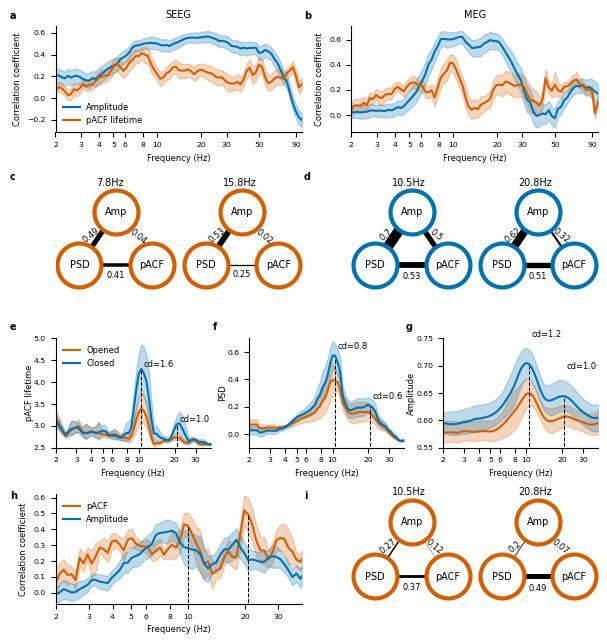

In [28]:
triangle_pos = {'PSD': np.array([-1.86602536, -0.50000003]), 
                'pACF': np.array([ 1.86602539, -0.49999997]), 
                'Amp': np.array([-2.91409249e-08,  1.00000000e+00])}


fig = plt.figure(figsize=(7,7.5), constrained_layout=False, dpi=100)
spec = fig.add_gridspec(nrows=8, ncols=6, hspace=1.5)

gs_list = [spec[:4, :].subgridspec(2,2, hspace=0.5),
           spec[4:6, :].subgridspec(2,3, hspace=0.1, wspace=0.25),
           spec[6:, :].subgridspec(1,2, hspace=0.5)]

axes = np.empty((5,3), dtype=object)

for i, j in itertools.product(range(2), range(2)):
    axes[i, j] = fig.add_subplot(gs_list[0][i, j])

for j in range(3):
    axes[2, j] = fig.add_subplot(gs_list[1][:2, j])    
    
for j in range(2):
    axes[4, j] = fig.add_subplot(gs_list[2][j])
    
axes[0,0].semilogx(f_vals, amp_corr_mean, color=ripples_blue, label='Amplitude')
axes[0,0].fill_between(f_vals, amp_corr_5, amp_corr_95, color=ripples_blue, alpha=0.25)

axes[0,0].semilogx(f_vals, pac_corr_mean, color=ripples_orange, label='pACF lifetime')
axes[0,0].fill_between(f_vals, pac_corr_5, pac_corr_95, color=ripples_orange, alpha=0.25)

axes[0,1].semilogx(f_vals, meg_cohort_amp_corr_mean, color=ripples_blue, label='Amplitude')
axes[0,1].fill_between(f_vals, meg_cohort_amp_corr_5, meg_cohort_amp_corr_95, color=ripples_blue, alpha=0.25)

axes[0,1].semilogx(f_vals, meg_cohort_pac_corr_mean, color=ripples_orange, label='pACF lifetime')
axes[0,1].fill_between(f_vals, meg_cohort_pac_corr_5, meg_cohort_pac_corr_95, color=ripples_orange, alpha=0.25)

draw_correlation_polygon(seeg_correlations_partial[...,28].mean(axis=0)[[1,0,2]], open_freqs_correlations_partial.mean(axis=1)[:, 34],
               ['PSD', 'pACF', 'Amp'], '7.8Hz', axes[1,0], pos=triangle_pos, node_color=ripples_orange, 
                         label_x=-1, x_offset=0, label_y=1.75, features=['corr'])
draw_correlation_polygon(seeg_correlations_partial[...,41].mean(axis=0)[[1,0,2]], open_freqs_correlations_partial.mean(axis=1)[:, 48],
               ['PSD', 'pACF', 'Amp'], '15.8Hz', axes[1,0], pos=triangle_pos, node_color=ripples_orange, 
                         label_x=5.5, x_offset=6.5, label_y=1.75, features=['corr'])

# seeg_correlations_partial

draw_correlation_polygon(closed_freqs_corr_mean[:, 34], closed_freqs_correlations_partial.mean(axis=1)[:, 34],
               ['PSD', 'pACF', 'Amp'], '10.5Hz', axes[1,1], pos=triangle_pos, node_color=ripples_blue, 
                         label_x=-1, x_offset=0, label_y=1.75, features=['corr'])
draw_correlation_polygon(closed_freqs_corr_mean[:, 48], closed_freqs_correlations_partial.mean(axis=1)[:, 48],
               ['PSD', 'pACF', 'Amp'], '20.8Hz', axes[1,1], pos=triangle_pos, node_color=ripples_blue, 
                         label_x=5.5, x_offset=6.5, label_y=1.75, features=['corr'])


for ax, data_open, data_closed, effect_size, ylim, label in zip(axes[2],
                                              [(pac_open_mean,pac_open_5, pac_open_95), 
                                               (psd_open_mean, psd_open_5, psd_open_95), 
                                               (amp_open_mean, amp_open_5, amp_open_95)],
                                              [(pac_closed_mean, pac_closed_5, pac_closed_95),
                                               (psd_closed_mean, psd_closed_5, psd_closed_95),
                                               (amp_closed_mean, amp_closed_5, amp_closed_95)],
                                              [pac_es, psd_es, amp_es],
                                              [(2.5, 5), (-0.1, 0.7), (0.55, 0.75)],
                                                  ['pACF lifetime', 'PSD', 'Amplitude']):
        
    ax.semilogx(f_vals, data_open[0], color=ripples_orange, label='Opened')
    ax.fill_between(f_vals, data_open[1], data_open[2], color=ripples_orange, alpha=0.25)
    ax.vlines(f_vals[[34, 48]], -3, data_closed[0][[34, 48]], color='black', ls='--', lw=0.75)

    ax.text(f_vals[34]*1.05, data_closed[0][34] + 0.05, f'cd={round(effect_size[34], 1)}', size=6)
    ax.text(f_vals[48]*1.05, data_closed[0][48] + 0.05, f'cd={round(effect_size[48], 1)}', size=6)

    ax.semilogx(f_vals, data_closed[0], color=ripples_blue, label='Closed')
    ax.fill_between(f_vals, data_closed[1], data_closed[2], color=ripples_blue, alpha=0.25)
    
    ax.set_xlim([2,40])
    ax.set_ylim(ylim)
    
    ax.set_ylabel(label, fontsize=6, labelpad=0.1)
    
    
axes[4,0].semilogx(f_vals, diff_freqs_corr_mean[0], color=ripples_orange, label='pACF')
axes[4,0].fill_between(f_vals, diff_freqs_corr_5[0], diff_freqs_corr_95[0], color=ripples_orange, alpha=0.25)


axes[4,0].semilogx(f_vals, diff_freqs_corr_mean[1], color=ripples_blue, label='Amplitude')
axes[4,0].fill_between(f_vals, diff_freqs_corr_5[1], diff_freqs_corr_95[1], color=ripples_blue, alpha=0.25)

axes[4,0].vlines(f_vals[[33, 48]], -0.1, diff_freqs_corr_mean[0][[33, 48]], color='black', ls='--', lw=0.75)


axes[4,0].set_ylim([-0.07, 0.62])

draw_correlation_polygon(diff_freqs_corr_mean[:, 34], open_freqs_correlations_partial.mean(axis=1)[:, 34], 
               ['PSD', 'pACF', 'Amp'], '10.5Hz', axes[4,1], pos=triangle_pos, node_color=ripples_orange, 
                         label_x=-1, label_y=1.75, features=['corr'])
draw_correlation_polygon(diff_freqs_corr_mean[:, 48], open_freqs_correlations_partial.mean(axis=1)[:, 48], 
               ['PSD', 'pACF', 'Amp'], '20.8Hz', axes[4,1], pos=triangle_pos, node_color=ripples_orange, 
                         label_x=5.5, x_offset=6.5, label_y=1.75, features=['corr'])


for ax in [axes[1,0], axes[1,1], axes[4,1]]:
    ax.set_ylim([-1.25, 1.75])


for ax, title in zip(axes[0], ['SEEG', 'MEG']):
    ax.set_title(title, fontsize=7)
    
for ax in axes[0, :2].tolist() + [axes[4,0]]:
    ax.set_ylabel('Correlation coefficient', fontsize=6)


for ax in axes[1, :2].tolist() + [axes[4,1]]:
    ax.set_xlim([-3.1, 9.6])

axes[0,0].legend(fontsize=6, frameon=False)
axes[2,0].legend(fontsize=6, frameon=False, loc=2)
axes[4,0].legend(fontsize=6, frameon=False)


for ax in axes[0, :2].tolist() + axes[2].tolist() + [axes[4,0]]:
    ax.set_xlabel('Frequency (Hz)', fontsize=6)

    ax.set_xticks([2,3,4,5,6,8,10,20,30, 50, 90])
    ax.tick_params(labelsize=5.5)
    
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.minorticks_off()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlim(f_vals[[0, ~0]])
    
    
for ax in axes[2].tolist() + [axes[4,0]]:
    ax.set_xlim([2,40])
    

for label, (xpos, ypos) in zip('achbdi', itertools.product([0.06, 0.48], [0.89, 0.675, 0.25])):
    fig.text(xpos, ypos, label, fontsize=7, weight='bold')

for label, (xpos, ypos) in zip('efg', itertools.product([0.06, 0.35, 0.625], [0.475])):
    fig.text(xpos, ypos, label, fontsize=7, weight='bold')

      
fig.savefig('publication_figures/figure_5.png', dpi=300, bbox_inches="tight")

for format in ['svg', 'pdf']:
    fig.savefig(f'publication_figures_vector/figure_5.{format}', dpi=300, bbox_inches="tight")

In [29]:
(open_corr_pac_5, open_corr_amp_5, _), (open_corr_pac_95, open_corr_amp_95, _) = np.percentile(open_freqs_corr_boot, (5,95), axis=0)
(closed_corr_pac_5, closed_corr_amp_5, _), (closed_corr_pac_95, closed_corr_amp_95, _) = np.percentile(closed_freqs_corr_boot, (5,95), axis=0)

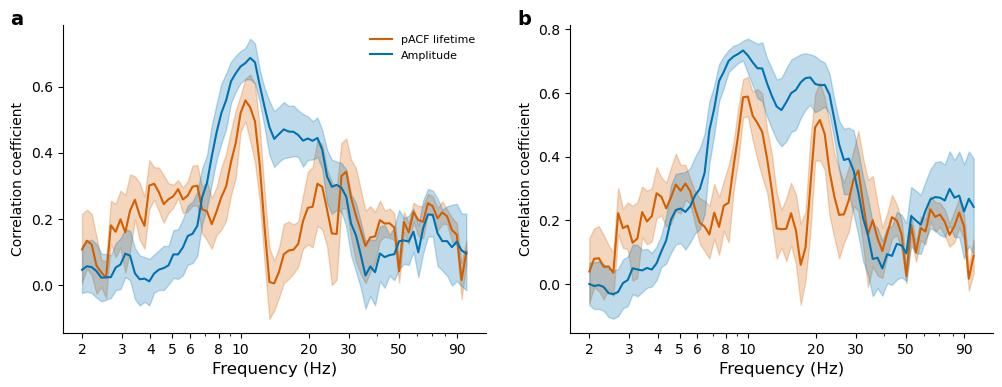

In [30]:
fig, axes = plt.subplots(figsize=(12,4), ncols=2)

axes[0].semilogx(f_vals, open_freqs_corr_boot[:, 0].mean(axis=0), color=ripples_orange, label='pACF lifetime')
axes[0].fill_between(f_vals, open_corr_pac_5, open_corr_pac_95, color=ripples_orange,  alpha=0.25)

axes[0].semilogx(f_vals, open_freqs_corr_boot[:, 1].mean(axis=0), color=ripples_blue, label='Amplitude',)
axes[0].fill_between(f_vals, open_corr_amp_5, open_corr_amp_95, color=ripples_blue, alpha=0.25)

axes[1].semilogx(f_vals, closed_freqs_corr_boot[:, 0].mean(axis=0), color=ripples_orange)
axes[1].fill_between(f_vals, closed_corr_pac_5, closed_corr_pac_95, color=ripples_orange, alpha=0.25)

axes[1].semilogx(f_vals, closed_freqs_corr_boot[:, 1].mean(axis=0), color=ripples_blue)
axes[1].fill_between(f_vals, closed_corr_amp_5, closed_corr_amp_95, color=ripples_blue, alpha=0.25)

axes[0].legend(frameon=False, fontsize=8)

for ax in axes:
    ax.set_xlabel('Frequency (Hz)', fontsize=12)
    ax.set_ylabel('Correlation coefficient')
    
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xticks([2,3,4,5,6,8,10,20,30, 50, 90])
    
for ax, label in zip(axes.flatten(), 
                     'ab'):
    ax.text(-0.125, 1, label, fontsize=14, transform=ax.transAxes, weight='bold')
    
    
fig.savefig('publication_figures/figure_5_supp.png', dpi=300, bbox_inches="tight")